### **1. Import Dependencies**

In [595]:
import pandas as pd
import numpy as np

import gc
import os
import requests
import json
import re

import concurrent.futures
import asyncio
import httpx
import multiprocessing

from urllib.parse import urlencode

from typing import List, Dict, Optional, Union
from glob import glob

import joblib

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.metrics import precision_score, recall_score, roc_auc_score

from sentence_transformers import SentenceTransformer
import fasttext
from gensim.models import KeyedVectors 

import tensorflow as tf
import tensorflow.keras as keras

from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import Dense, LSTM, Bidirectional, Input, Lambda, Dot, Layer
from keras.callbacks import EarlyStopping

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\msi.pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\msi.pc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### **2. Settings**

In [404]:
tf.random.set_seed(42)

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)

### **2. Load Data**

In [ ]:
def fetch_data(url: str, params=None):
  try:
    response = requests.get(url, params=params)
    if (response.status_code == 200):
      return response.json()
    
    print(f"Error response with status code: {response.status_code}")
  except Exception as error:
    print(f'Failed to fetch data: {error}')

def urls_builder(base_url: str, n_fetch: int, limit: int, products: List[str], **kwargs):
  urls = []
  for product in products:
    for i in range(n_fetch):
      
      param = {
        'offset': i * limit,
        'limit': limit,
        'product': product,
        **kwargs,
      }
      
      full_url = base_url + '?' + urlencode(param)
      urls.append(full_url)
    
  return urls

def save_json(data, path: str):
  with open(path, 'w') as json_file:
    json.dump(data, json_file)

def load_json(path: str):
  with open(path, 'r') as json_file:
    loaded_data = json.load(json_file)
  return loaded_data

In [ ]:
%%script skipped # Skipped due to resource optimization

selected_fields = ['id', 'duplicates', 'summary', 'description', 'status', 'resolution', 'platform', 'product', 'type', 'priority', 'severity', 'component']
products = ['Firefox']

base_params = {
  'include_fields': ', '.join(selected_fields),
}
saved_data_path = os.path.join('data', 'raw_data', 'firefox_raw_data.json')

base_url = 'https://bugzilla.mozilla.org/rest/bug'
n_fetch = 50
limit = 5000

if os.path.exists(saved_data_path):
  response_data = load_json(saved_data_path)
else:
  urls = urls_builder(base_url, n_fetch, limit, products, **base_params)
  response_data = []

  max_workers = 50
  with concurrent.futures.ThreadPoolExecutor(max_workers) as executor:
    response_data = list(executor.map(fetch_data, urls))
    
  response_data = [item['bugs'] for item in response_data]
  response_data = [item for sublist in response_data for item in sublist]
  
  save_json(response_data, saved_data_path)

In [ ]:
raw_data_path = os.path.join('data', 'cache', 'raw_data.parquet')
df = pd.DataFrame()

if (os.path.exists(raw_data_path)):
  df = pd.read_parquet(raw_data_path)
else:
  data_paths = glob(os.path.join('data', 'raw_data', 'firefox_raw_data.json'))

  for path in data_paths:
    data = load_json(path)
    data = pd.DataFrame(data)
    df = pd.concat([df, data])

  df = df.set_index('id')
  df.to_parquet(raw_data_path)

df.head()

In [ ]:
df = df.drop(['status', 'priority', 'resolution', 'severity', 'component', 'product'], axis=1)

In [ ]:
df.info(memory_usage='deep')

### **3. EDA**

### **3.1. Missing Values**

In [ ]:
df.isna().sum()

### **3.2. Product**

In [ ]:
%%script skipped # Skipped due to resource optimization

df['product'].value_counts(ascending=False)

### **3.3. Platform**

In [ ]:
df['platform'].value_counts(ascending=False)

### **3.4. Type**

In [ ]:
df['type'].value_counts(ascending=False)

### **3.5. Duplicates**

In [ ]:
duplicates = df['duplicates'].apply(lambda x: len(x)).sort_values(ascending=False)
duplicates

In [ ]:
duplicated_bugs = duplicates[duplicates > 0]
duplicated_bugs.count()

### **4. Feature Engineering**

### **4.1. Missing Values**

In [ ]:
df.loc[df['type'] == '--', 'type'] = 'no type'

### **4.2. Duplicates**

In [ ]:
duplicated = df.loc[duplicated_bugs.index, 'duplicates']
duplicated

In [ ]:
data_path = os.path.join('data', 'cache', 'duplicate_to_data.parquet')

if (os.path.exists(data_path)):
  df = pd.read_parquet(data_path)
else:
  df['duplicates_to'] = -1

  for idx, dups in zip(duplicated.index, duplicated):
    for item in dups:
      df.loc[df.index == item, 'duplicates_to'] = idx
      
  df.to_parquet(data_path)

In [ ]:
df = df.drop(columns=['duplicates'])

### **4.3. Clean Sentences**

In [ ]:
def remove_special_chars(text: str):
  text = text.lower()
  text = re.sub(r'\n|\t|\r|\0', ' ', text)
  text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
  text = re.sub(r'\s{2,}', ' ', text)
  text = re.sub(r'\s$', '', text)
  text = re.sub(r'\s[b-z]\s', ' ', text)
  text = re.sub(r'\s[b-z]\s', ' ', text)
  
  return text

def remove_stopwords(text: str):
  stop_words = set(stopwords.words('english'))
  words = word_tokenize(text)
  filtered_words = [word for word in words if word not in stop_words]
  
  return ' '.join(filtered_words)

def clean_text(text: str):
  text = remove_special_chars(text)
  text = remove_stopwords(text)
  
  return text

df['platform'] = df['platform'].apply(clean_text)
df['summary'] = df['summary'].apply(clean_text)
df['type'] = df['type'].apply(clean_text)
df['description'] = df['description'].apply(clean_text)

# df['product'] = df['product'].apply(clean_text)

### **4.4. Combined Text**

In [ ]:
df['text'] = df['type'] + ' ' + df['platform'] + ' ' + df['summary'] + ' ' + df['description']

In [ ]:
df = df[['text', 'duplicates_to']]

df.head()

### **4.5. Sentence Embedding**

In [ ]:
# %%script skipped # Skipped

sent_embd_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [152]:
# %%script skipped # Skipped

embd_data_path = os.path.join('data', 'cache', 'sent_trans_embd_data.parquet')

if (os.path.exists(embd_data_path)):
  df = pd.read_parquet(embd_data_path)
else:
  df['text_embedded'] = df['text'].apply(sent_embd_model.encode)
  df.to_parquet(embd_data_path)

df['text_embedded'] = df['text_embedded'].apply(np.array)
gc.collect()

1569

In [ ]:
# %%script skipped # Skipped

model_path = os.path.join('models', 'wiki-news-300d-1M-subword.vec')
sent_embd_model = KeyedVectors.load_word2vec_format(model_path, binary=False)

In [39]:
# %%script skipped # Skipped

def sentence_embedding(sentence, model):
    words = word_tokenize(sentence)
    words_in_vocab = [word for word in words if word in model]

    if not words_in_vocab:
        return None

    embedding = np.mean([model[word] for word in words_in_vocab], axis=0)
    embedding = normalize(embedding.reshape(1, -1), norm='l2').reshape(-1)
    
    return embedding

In [112]:
# %%script skipped # Skipped

embd_data_path = os.path.join('data', 'cache', 'fasttext_embd_data.parquet')

if (os.path.exists(embd_data_path)):
  df = pd.read_parquet(embd_data_path)
else:
  df['text_embedded'] = df['text'].apply(sentence_embedding, model=sent_embd_model)
  df.to_parquet(embd_data_path)

df['text_embedded'] = df['text_embedded'].apply(np.array)
gc.collect()

0

In [41]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 210693 entries, 10954 to 1876223
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   text           210693 non-null  object
 1   duplicates_to  210693 non-null  int64 
 2   text_embedded  210693 non-null  object
dtypes: int64(1), object(2)
memory usage: 450.2 MB


### **4.6. Sentence Pairs**

In [153]:
df = df.reset_index()

In [154]:
df_duplicates = df[df['duplicates_to'] != -1].copy()
df_uniques = df[df['duplicates_to'] == -1].copy()

In [155]:
df_duplicates = pd.merge(left=df_duplicates,
                        right=df_uniques,
                        left_on='duplicates_to',
                        right_on='id',
                        suffixes=('__left', '__right'))
df_duplicates = df_duplicates.drop(columns=['duplicates_to__left', 'duplicates_to__right'])
df_duplicates['label'] = 1
df_duplicates = df_duplicates.reset_index(drop=True)

df_duplicates.head()

,id__left,text__left,text_embedded__left,id__right,text__right,text_embedded__right,label
0,46407,enhancement current url querried another app ...,"[-0.03849341, 0.044417124, 0.061231103, 0.0028...",516502,defect add applescript support getting curren...,"[-0.068924494, -0.0365692, 0.017821774, -0.005...",1
1,491005,defect powerpc applescript error get class cur...,"[-0.042833928, -0.019467501, -0.0014609282, 0....",516502,defect add applescript support getting curren...,"[-0.068924494, -0.0365692, 0.017821774, -0.005...",1
2,95091,defect x86 helper application lack mozilla 0 9...,"[-0.07100523, -0.028381774, 0.023365201, 0.037...",57420,defect support helper app command line args u...,"[0.030665655, -0.08451681, -0.060907457, -0.08...",1
3,308815,defect x86 linux choose helper application all...,"[-0.005184613, -0.028351225, -0.08792038, 0.01...",57420,defect support helper app command line args u...,"[0.030665655, -0.08451681, -0.060907457, -0.08...",1
4,392205,enhancement add support arguments help apps u...,"[0.014655771, -0.03146617, -0.08758416, 0.0324...",57420,defect support helper app command line args u...,"[0.030665655, -0.08451681, -0.060907457, -0.08...",1


In [156]:
half_rows = df_uniques.shape[0] // 2
df_uniques = df_uniques.sample(frac=1, replace=False, random_state=42)

df_uniques_temp = pd.DataFrame()
df_uniques_temp['text_embedded__left'] = df_uniques['text_embedded']
df_uniques_temp['text__left'] = df_uniques['text']
df_uniques_temp['id__left'] = df_uniques['id']

df_uniques_temp['text_embedded__right'] = df_uniques['text_embedded'].shift(1)
df_uniques_temp['text__right'] = df_uniques['text'].shift(1)
df_uniques_temp['id__right'] = df_uniques['id'].shift(1)

df_uniques_temp = df_uniques_temp.dropna()
df_uniques_temp['label'] = 0

df_uniques = df_uniques_temp.reset_index(drop=True)

del df_uniques_temp
gc.collect()

df_uniques.head()

,text_embedded__left,text__left,id__left,text_embedded__right,text__right,id__right,label
0,"[0.013469558, -0.010111869, 0.028897135, -0.00...",defect x86 search without dialog new search di...,264962,"[-0.012708805, 0.036860116, 0.09029018, 0.1036...",defect x86 getelementsbytagname confused short...,293692.0,0
1,"[-0.05257168, -0.01263137, 0.089446604, -0.017...",defect unspecified colour updates needed new t...,1451474,"[0.013469558, -0.010111869, 0.028897135, -0.00...",defect x86 search without dialog new search di...,264962.0,0
2,"[-0.0056334394, -0.014998359, 0.036152463, 0.0...",defect x86 64 one word urlbar searches incredi...,972452,"[-0.05257168, -0.01263137, 0.089446604, -0.017...",defect unspecified colour updates needed new t...,1451474.0,0
3,"[-0.03328692, -0.017311642, 0.02710121, -0.015...",defect x86 firefox installer handle directory ...,341797,"[-0.0056334394, -0.014998359, 0.036152463, 0.0...",defect x86 64 one word urlbar searches incredi...,972452.0,0
4,"[0.04823823, -0.0018696992, -0.056124125, -0.0...",defect x86 firefox 18 0b1 b2 segmentation faul...,817482,"[-0.03328692, -0.017311642, 0.02710121, -0.015...",defect x86 firefox installer handle directory ...,341797.0,0


In [157]:
df = pd.concat([df_duplicates, df_uniques], axis=0).sample(frac=1, replace=False, random_state=42).reset_index(drop=True)
gc.collect()

0

### **5. Data Split**

### **5.1. Train Test Split**

In [846]:
X, X_test, y, y_test = train_test_split(df[['text_embedded__left', 'text_embedded__right']],
                                                    df['label'],
                                                    shuffle=True,
                                                    stratify=df['label'],
                                                    test_size=0.3,
                                                    random_state=42)

print(f'Shape of X_train: {X.shape}')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_train: {y.shape}')
print(f'Shape of y_test: {y_test.shape}')

Shape of X_train: (146384, 2)
Shape of X_test: (62737, 2)
Shape of y_train: (146384,)
Shape of y_test: (62737,)


### **5.2. Data Fold**

In [742]:
n_splits = 5

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

### **6. Model Preparation**

In [847]:
input_1 = Input(shape=(384, ), name='input_1')
input_2 = Input(shape=(384, ), name='input_2')

shared_node_1 = Dense(256, name='shared_node_1')
shared_node_2 = Dense(256, name='shared_node_2')
shared_node_3 = Dense(128, name='shared_node_3')
shared_node_4 = Dense(128, name='shared_node_4')

x1 = shared_node_1(input_1)
x1 = shared_node_2(x1)
x1 = shared_node_3(x1)
x1 = shared_node_4(x1)

x2 = shared_node_1(input_2)
x2 = shared_node_2(x2)
x2 = shared_node_3(x2)
x2 = shared_node_4(x2)

cosine_similarity_layer = Dot(axes=-1, normalize=True, name='cosine_similarity')([x1, x2])
output_layer = Dense(1, activation='sigmoid', name='output')(cosine_similarity_layer)

training_model = Model(inputs=[input_1, input_2], outputs=output_layer, name='training_model')

optimizer = keras.optimizers.Adam(learning_rate=0.002)
loss = keras.losses.BinaryCrossentropy(from_logits=False)

training_model.compile(loss=loss, optimizer=optimizer, metrics=[keras.metrics.Precision(), keras.metrics.Recall()])

training_model.summary()

Model: "training_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 384)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 384)]                0         []                            
                                                                                                  
 shared_node_1 (Dense)       (None, 256)                  98560     ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 shared_node_2 (Dense)       (None, 256)                  65792     ['shared_node_1[0

### **7. Model Training**

### **7.1. Traning Preparation**

In [890]:
tf.random.set_seed(42)
gc.collect()

9414

In [891]:
def train_model(X_train, X_valid, y_train, y_valid, batch_size, epochs, callbacks=None, verbose='auto'):
  training_model.fit(X_train,
                       y_train,
                       epochs=epochs,
                       batch_size=batch_size,
                       validation_data=(X_valid, y_valid),
                       callbacks=[*callbacks],
                       verbose=verbose)
    
  train_score = training_model.evaluate(X_train, y_train, verbose=verbose)[1:]
  valid_score = training_model.evaluate(X_valid, y_valid, verbose=verbose)[1:]
  
  return (train_score, valid_score)

### **7.2. Model Training**

In [882]:
epochs = 10
batch_size = 32

train_scores = []
valid_scores = []

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    X_train_inputs = [np.vstack(X_train['text_embedded__left']), np.vstack(X_train['text_embedded__right'])]
    X_valid_inputs = [np.vstack(X_valid['text_embedded__left']), np.vstack(X_valid['text_embedded__right'])]
    
    early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    
    train_score, valid_score = train_model(X_train_inputs,
                                           X_valid_inputs,
                                           y_train,
                                           y_valid,
                                           batch_size=batch_size,
                                           epochs=epochs,
                                           callbacks=[early_stopping],
                                           verbose=0)
    
    print(f'fold-{fold + 1}: train - precision = {train_score[0]}, recall = {train_score[1]}')
    print(f'fold-{fold + 1}: valid - precision = {valid_score[0]}, recall = {valid_score[1]}')
    print('-' * 200)
    
    train_scores.append(train_score)
    valid_scores.append(valid_score)
    
train_scores_avg = np.mean(train_scores, axis=0)
valid_scores_avg = np.mean(train_scores, axis=0)

print(f'average_score: train - precision = {train_scores_avg[0]}, recall = {train_scores_avg[1]}')
print(f'average_score: valid - precision = {valid_scores_avg[0]}, recall = {valid_scores_avg[1]}')

fold-1: train - precision = 0.9321084022521973, recall = 0.9087702035903931
fold-1: valid - precision = 0.8746867179870605, recall = 0.8691200613975525
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
fold-2: train - precision = 0.9238320589065552, recall = 0.9177618026733398
fold-2: valid - precision = 0.8732782602310181, recall = 0.877144455909729
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
fold-3: train - precision = 0.9380005598068237, recall = 0.9073113203048706
fold-3: valid - precision = 0.8902438879013062, recall = 0.8683264255523682
-----------------------------------------------------------------------------------------------------------------------------------------------

### **7.3. Save/Load Model**

In [899]:
saved_model_path = os.path.join('models', 'model.pkl')
# joblib.dump(training_model, saved_model_path)

training_model = joblib.load(saved_model_path)

### **7.4. Model Evaluation**

In [900]:
val_predictions = training_model.predict([np.vstack(X_test['text_embedded__left']), np.vstack(X_test['text_embedded__right'])])
val_predictions_binary = (val_predictions > 0.5).astype(int)

precision = precision_score(y_test, val_predictions_binary)
recall = recall_score(y_test, val_predictions_binary)
auc = roc_auc_score(y_test, val_predictions_binary)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'AUC: {auc:.4f}')

1961/1961 [==============================] - 3s 2ms/step
Precision: 0.8672
Recall: 0.8492
AUC: 0.9154


### **7.5. Embedding Model Preparation**

In [901]:
embd_input = Input(shape=(384, ), name='input')
embd_hidden = training_model.get_layer('shared_node_1')(embd_input)
embd_hidden = training_model.get_layer('shared_node_2')(embd_hidden)
embd_hidden = training_model.get_layer('shared_node_3')(embd_hidden)
embd_output = training_model.get_layer('shared_node_4')(embd_hidden)

embd_model = Model(inputs=embd_input, outputs=embd_output, name='embd_inference_model')
embd_model.summary()

Model: "embd_inference_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 384)]             0         
                                                                 
 shared_node_1 (Dense)       (None, 256)               98560     
                                                                 
 shared_node_2 (Dense)       (None, 256)               65792     
                                                                 
 shared_node_3 (Dense)       (None, 128)               32896     
                                                                 
 shared_node_4 (Dense)       (None, 128)               16512     
                                                                 
Total params: 213760 (835.00 KB)
Trainable params: 213760 (835.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### **7.6. Embedding Model Evaluation**

In [902]:
def custom_cosine_similarity(text_1: np.ndarray, text_2: np.ndarray):
    dot_product = np.dot(text_1, text_2)
    norm_text_1 = np.linalg.norm(text_1)
    norm_text_2 = np.linalg.norm(text_2)
    
    similarity = dot_product / (norm_text_1 * norm_text_2)
    
    return similarity

In [903]:
embd_test_left = embd_model.predict(np.vstack(X_test['text_embedded__left']))
embd_test_right = embd_model.predict(np.vstack(X_test['text_embedded__right']))
embd_similarity = np.array([custom_cosine_similarity(embd_1, embd_2) for embd_1, embd_2 in zip(embd_test_left, embd_test_right)])

1961/1961 [==============================] - 3s 1ms/step


In [904]:
def evaluate_model(similarity_scores: np.ndarray, threshold: float):
  embd_binary_similarity = (similarity_scores > threshold).astype(int)

  precision = precision_score(y_test, embd_binary_similarity)
  recall = recall_score(y_test, embd_binary_similarity)
  auc = roc_auc_score(y_test, embd_binary_similarity)
  
  return [precision, recall, auc]

In [908]:
threshold_eval = pd.DataFrame([[threshold, *evaluate_model(embd_similarity, threshold)] for threshold in np.linspace(0, 1, 1000)], columns=['threshold', 'precision', 'recall', 'auc'])
threshold_eval.sort_values(by='auc', ascending=False)

,threshold,precision,recall,auc
501,0.501502,0.711361,0.932989,0.939836
500,0.500501,0.709741,0.933247,0.939747
498,0.498498,0.706267,0.934151,0.939717
488,0.488488,0.692000,0.938154,0.939673
502,0.502503,0.713382,0.931956,0.939611
...,...,...,...,...
995,0.995996,1.000000,0.025178,0.512589
996,0.996997,1.000000,0.024661,0.512331
997,0.997998,1.000000,0.023370,0.511685
998,0.998999,1.000000,0.022853,0.511427


<Axes: title={'center': 'Metrics Evaluation'}, xlabel='Threshold', ylabel='Metric score'>

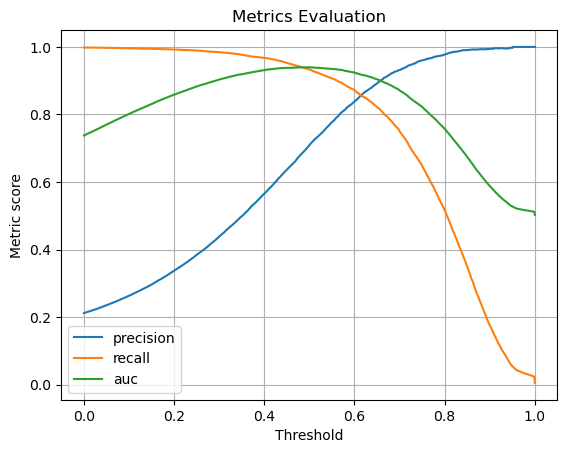

In [909]:
threshold_eval.plot(kind='line',
                    title='Metrics Evaluation',
                    x='threshold',
                    xlabel='Threshold',
                    ylabel='Metric score',
                    grid=True)

In [914]:
model_eval = evaluate_model(embd_similarity, 0.84)

print(f'Precision: {model_eval[0]:.5f}')
print(f'Recall: {model_eval[1]:.5f}')
print(f'AUC: {model_eval[2]:.5f}')

Precision: 0.99034
Recall: 0.38399
AUC: 0.69173
